In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import cache_magic
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
import concurrent.futures
from copy import deepcopy

from tracking_v2.target import ConstantVelocityTarget, SingleTurnTarget
from tracking_v2.kalman import LinearKalmanFilter, CoordinatedTurn
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel, SingerAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import Runner, evaluate_nees, plot_error, plot_3d

from tracking.util import to_df

In [38]:
class AirVehicleMover:
    def __init__(self, initial_position, initial_velocity, mass, thrust_force, drag_coefficient):
        """
        Initialize the air vehicle mover.
        
        :param initial_position: Initial 3D position vector (x, y, z)
        :param initial_velocity: Initial 3D velocity vector (vx, vy, vz)
        :param mass: Mass of the vehicle in kg
        :param thrust_force: Maximum thrust force in Newtons
        :param drag_coefficient: Drag coefficient (dimensionless)
        """
        self.position = np.asarray(initial_position, dtype=float)
        self.velocity = np.asarray(initial_velocity, dtype=float)
        self.mass = mass
        self.thrust_force = thrust_force
        self.drag_coefficient = drag_coefficient
        
        self.initial_position = np.asarray(initial_position, dtype=float)
                
    def update(self, dt, target, randomness_scale=1.0):
        """
        Update the vehicle's position and velocity for one time step.

        :param dt: Time step in seconds
        :param requested_heading: Desired heading as a unit vector (x, y, z)
        :param randomness_scale: Scale for random acceleration, affects how much the velocity changes randomly
        """
        
        # Calculate direction towards target
        direction_to_target = target - self.position
        distance_to_target = np.linalg.norm(direction_to_target)
        
        # Normalize direction vector
        if distance_to_target == 0:
            return True
        
        direction_to_target /= distance_to_target
        
        # Calculate drag force
        drag_force = -0.5 * self.drag_coefficient * np.linalg.norm(self.velocity)**2 * self.velocity
        
        # Random acceleration (normally distributed)
        random_acceleration = np.random.normal(0, randomness_scale, 3)
        
        # Net acceleration
        net_acceleration = (self.thrust_force * direction_to_target / self.mass + 
                            drag_force / self.mass + 
                            random_acceleration)
        
        # Update velocity, trying to move towards the target
        self.velocity += net_acceleration * dt

        # Update position
        self.position = self.position + self.velocity * dt
        
        # Define the normal vector for the plane which defines the end of this leg
        normal = target - self.initial_position
        
        # if cosinus between these two vectors is negative, we moved past the target
        if np.dot(normal, target - self.position) < 0:
            return True
        
        return False
        

    def get_state(self):
        """
        Return the current state of the vehicle.
        
        :return: Tuple of (position, velocity)
        """
        return self.position, self.velocity
    
    def simulate(self, dt=.1, t_max=100):
        initial_pos = [0, 0, 0]  # Starting at origin
        initial_vel = [10, 0, 0]  # Moving initially along x-axis
        target = np.array([2000, 0, 0])

        trace = []
        for t in np.arange(0, t_max, dt):
            vehicle.update(dt, target)
            position, velocity = vehicle.get_state()
            trace.append(np.concatenate(([t], position, velocity)))

        return np.asarray(trace)

In [39]:
vehicle = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=5000, drag_coefficient=0.05)
trace   = vehicle.simulate()
df      = to_df(trace, columns=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
df

,t,x,y,z,vx,vy,vz
0,0.0,1.040637,0.014386,-0.009509,10.406367,0.143856,-0.095093
1,0.1,2.140797,0.035578,-0.016968,11.001599,0.211928,-0.074584
2,0.2,3.298344,0.061130,-0.018505,11.575469,0.255513,-0.015369
3,0.3,4.504779,0.071623,-0.018559,12.064352,0.104933,-0.000549
4,0.4,5.777361,0.093373,-0.006348,12.725827,0.217504,0.122115
...,...,...,...,...,...,...,...
995,99.5,1904.185104,-28.030168,31.695512,8.124596,2.748562,-2.531429
996,99.6,1905.042188,-27.728760,31.411340,8.570836,3.014079,-2.841724
997,99.7,1905.942956,-27.400830,31.107812,9.007681,3.279305,-3.035279
998,99.8,1906.897828,-27.048753,30.784541,9.548721,3.520768,-3.232711


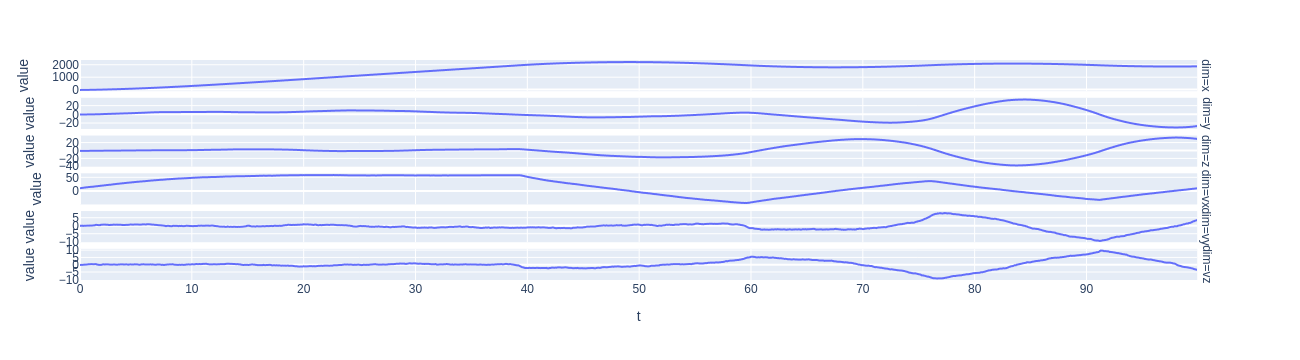

In [40]:
fig = ex.line(df.melt(['t'], ['x', 'y', 'z', 'vx', 'vy', 'vz'], 'dim', 'value'), x='t', y='value', facet_row='dim')
fig.update_yaxes(matches=None)
fig

In [41]:
vehicle = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=5000, drag_coefficient=0.05)
trace   = vehicle.simulate(t_max=400)
df      = to_df(trace, columns=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])

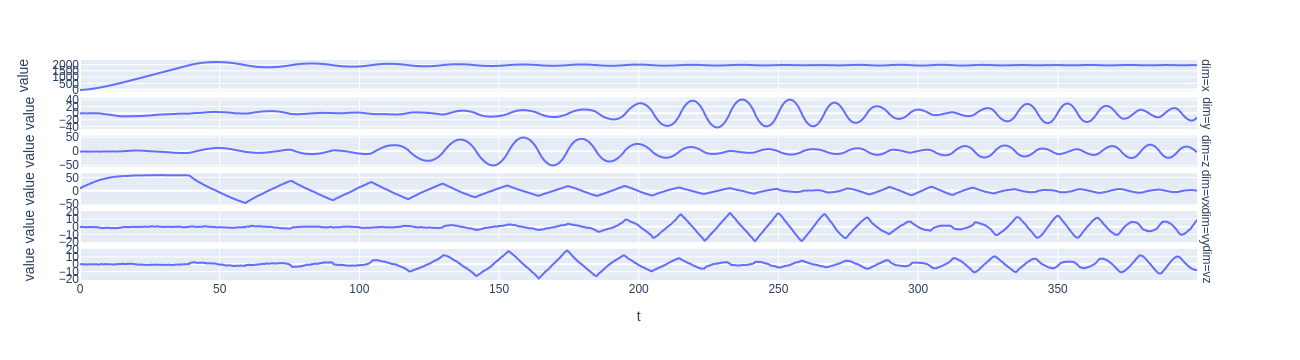

In [43]:
fig = ex.line(df.melt(['t'], ['x', 'y', 'z', 'vx', 'vy', 'vz'], 'dim', 'value'), x='t', y='value', facet_row='dim')
fig.update_yaxes(matches=None)
fig

### Enhanced

In [ ]:
import numpy as np

class AirVehicleMover:
    def __init__(self, initial_position, initial_velocity, mass, thrust_force, drag_coefficient, max_turn_rate):
        """
        Initialize the air vehicle mover.
        
        :param initial_position: Initial 3D position vector (x, y, z)
        :param initial_velocity: Initial 3D velocity vector (vx, vy, vz)
        :param mass: Mass of the vehicle in kg
        :param thrust_force: Maximum thrust force in Newtons
        :param drag_coefficient: Drag coefficient (dimensionless)
        :param max_turn_rate: Maximum turn rate in radians per second
        """
        self.position = np.array(initial_position, dtype=float)
        self.velocity = np.array(initial_velocity, dtype=float)
        self.mass = mass
        self.thrust_force = thrust_force
        self.drag_coefficient = drag_coefficient
        self.target_point = None
        self.initial_position = np.array(initial_position, dtype=float)
        self.max_turn_rate = max_turn_rate  # Maximum turn rate in rad/s

    def set_target(self, target_point):
        """
        Set the target point for the vehicle to move towards.

        :param target_point: The 3D point to move towards
        """
        self.target_point = np.array(target_point)

    def update(self, dt, randomness_scale=1.0):
        """
        Update the vehicle's position and velocity for one time step.

        :param dt: Time step in seconds
        :param randomness_scale: Scale for random acceleration, affects how much the velocity changes randomly
        """
        if self.target_point is None:
            raise ValueError("No target point set. Please set a target using set_target() method.")

        # Vector from initial position to target
        path_vector = self.target_point - self.initial_position
        path_length = np.linalg.norm(path_vector)
        path_unit = path_vector / path_length if path_length > 0 else np.zeros(3)

        # Current position error from the path
        to_current = self.position - self.initial_position
        along_path = np.dot(to_current, path_unit) * path_unit
        cross_track_error = to_current - along_path

        # Desired direction (minimize cross-track error)
        desired_direction = path_unit - cross_track_error / (path_length if path_length > 0 else 1)

        # Normalize desired direction
        desired_direction /= np.linalg.norm(desired_direction)

        # Current velocity direction
        current_velocity_direction = self.velocity / np.linalg.norm(self.velocity) if np.linalg.norm(self.velocity) > 0 else np.zeros(3)

        # Calculate angle between current direction and desired direction
        angle = np.arccos(np.clip(np.dot(current_velocity_direction, desired_direction), -1.0, 1.0))

        # Limit turn rate
        max_angle = self.max_turn_rate * dt
        if angle > max_angle:
            # Use the Rodrigues' rotation formula to rotate within max turn rate
            k = np.cross(current_velocity_direction, desired_direction)
            k /= np.linalg.norm(k)
            rotation_matrix = (np.eye(3) + np.sin(max_angle) * self.skew_symmetric(k) 
                               + (1 - np.cos(max_angle)) * np.dot(self.skew_symmetric(k), self.skew_symmetric(k)))
            new_direction = np.dot(rotation_matrix, current_velocity_direction)
        else:
            new_direction = desired_direction

        # Apply forces
        thrust_force = self.thrust_force * new_direction / self.mass
        drag_force = -0.5 * self.drag_coefficient * np.linalg.norm(self.velocity)**2 * self.velocity
        random_acceleration = np.random.normal(0, randomness_scale, 3)

        # Net acceleration
        net_acceleration = thrust_force + drag_force / self.mass + random_acceleration

        # Update velocity
        self.velocity += net_acceleration * dt

        # Update position
        self.position += self.velocity * dt

    def skew_symmetric(self, v):
        """Return the skew-symmetric matrix of vector v."""
        return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

    def get_state(self):
        """
        Return the current state of the vehicle.
        
        :return: Tuple of (position, velocity)
        """
        return self.position, self.velocity

# Example usage
if __name__ == "__main__":
    initial_pos = [0, 0, 0]  # Starting at origin
    initial_vel = [10, 0, 0]  # Moving initially along x-axis
    vehicle = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=5000, drag_coefficient=0.05, max_turn_rate=np.pi/4)  # 45 degrees per second max turn
    
    vehicle.set_target([100, 100, 0])  # Target at x=100, y=100
    
    dt = 0.1  # time step of 0.1 seconds
    for t in range(1000):  # Simulate for 100 seconds (1000 steps)
        vehicle.update(dt)
        position, velocity = vehicle.get_state()
        print(f"Time: {t*dt:.2f}s, Position: {position}, Velocity: {velocity}")
        if np.linalg.norm(position - vehicle.target_point) < 1:  # Within 1 unit of target
            print("Target reached")
            break